# Intro to HTTP caching in python

In [ ]:
# Demo dependencies and helper functions
!pip install -U requests requests-cache
!pip install -U aiohttp-client-cache rich pygithub pyinaturalist pymongo

from typing import Mapping

from rich import pretty, print


def pprint(obj):
    """A bit of extra formatting when printing a dictionary of headers"""
    if isinstance(obj, Mapping):
        for k in sorted(obj):
            print(f'[bold cyan]{k}[/bold cyan]: {obj[k]}')
    else:
        pretty.pprint(obj)

# Caching basics

Basic example with [functools.lru_cache](https://docs.python.org/3/library/functools.html#functools.lru_cache):

In [ ]:
from datetime import datetime, timedelta
from functools import lru_cache

import requests


@lru_cache(maxsize=32)
def get_pep(num):
    """Retrieve text of a Python Enhancement Proposal"""
    url = f'https://peps.python.org/pep-{num:0>4}/'
    return requests.get(url).text


for n in [8, 290, 308, 320, 8, 218, 320, 279, 289, 320, 9991, 8]:
    pep = get_pep(n)
    print(f'PEP {n:<4} text length: {len(pep)}')


get_pep.cache_info()

Limitations:
* Cache is stored only in memory and not persistent
* Only works for static resources
* No way to specify if/when to refresh cached pages
* requests are matched based only on function arguments

# HTTP Caching basics

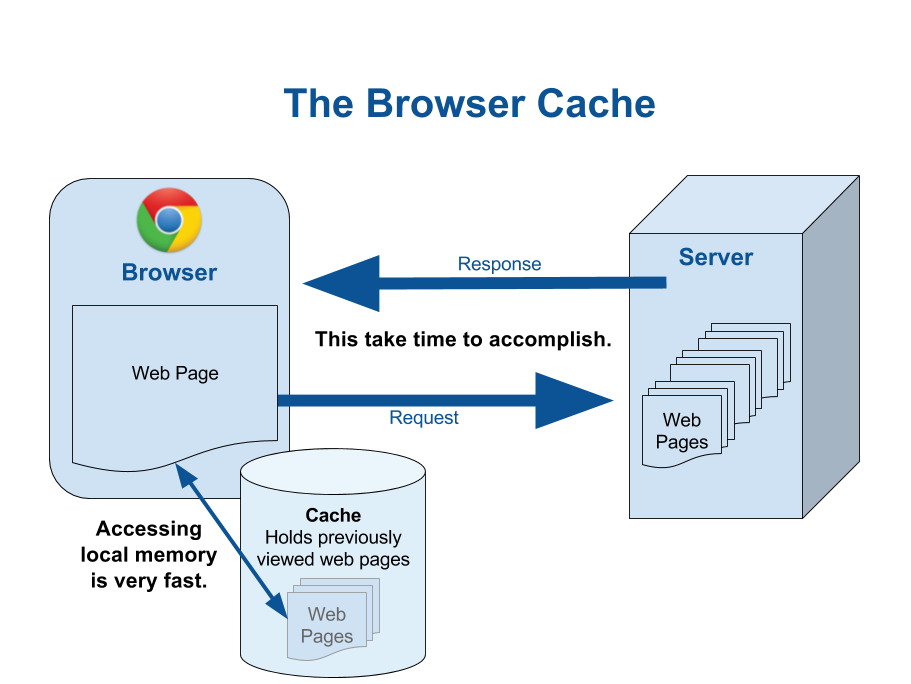

## Browser cache layers
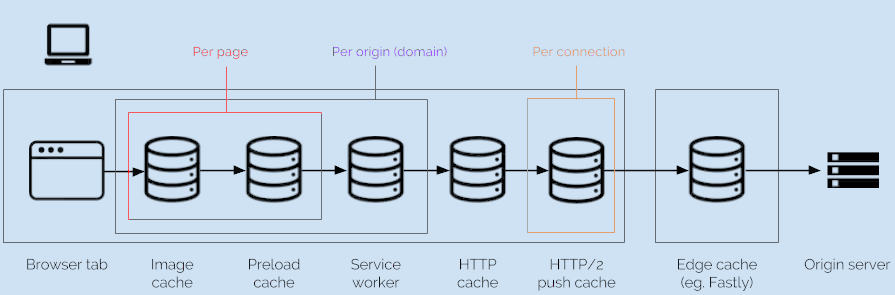

## Types of caches
* Server-side
* Public (proxy/edge/CDN)
* Private (browser/other client)

## Reference
Main specs (wall of text warning):
* [RFC 2616](https://datatracker.ietf.org/doc/html/rfc2616#section-13)
* [RFC 7234](https://datatracker.ietf.org/doc/html/rfc7234)

Extensions:
* [RFC 5861](https://datatracker.ietf.org/doc/html/rfc5861)
* [RFC 8246](https://datatracker.ietf.org/doc/html/rfc8246)

More readable summaries:
* [MDN: HTTP caching](https://developer.mozilla.org/en-US/docs/Web/HTTP/Caching)
* [MDN: Cache-Control](https://developer.mozilla.org/en-US/docs/Web/HTTP/Headers/Cache-Control#up-to-date_contents_always)
* [MDN: ETag](https://developer.mozilla.org/en-US/docs/Web/HTTP/Headers/ETag) and [If-None-Match](https://developer.mozilla.org/en-US/docs/Web/HTTP/Headers/If-None-Match)

# Python HTTP clients

A quick review of python HTTP clients:
* (1996?) [httplib](https://docs.python.org/2.7/library/http.client.html): Basic, low-level client in the standard library, kinda not great
    * Renamed to [http.client](https://docs.python.org/3/library/http.client.html) in python3
* (2003) [PycURL](http://pycurl.io): Python bindings for `libcurl`; advanced features, but not for the faint of heart
* (2007) [httplib2](https://httplib2.readthedocs.io): Client with more features; unrelated to the stdlib module
* (2010) [urllib3](https://urllib3.readthedocs.io): A higher-level, basically "what should have been in the stdlib"
* (2011) [requests](https://requests.readthedocs.io): "For humans," focusing on developer experience; built on urllib3
* (2014) [aiohttp](https://docs.aiohttp.org): Async client and server
* (2019) [httpx](https://www.python-httpx.org): Client based on the `requests` API, with HTTP/2 and async support

# requests-cache

The [requests-cache](https://github.com/requests-cache/requests-cache) library gives you an easy drop-in replacement for [requests.Session](https://requests.readthedocs.io/en/latest/user/advanced/#session-objects):

In [ ]:
from requests import Session
from requests_cache import CachedSession

# Instead of this:
session = Session()
r = session.get('https://httpbin.org/delay/2')

# Do this:
session = CachedSession()
r = session.get('https://httpbin.org/delay/2')

## Benchmark
After being cached, the only I/O operation for a given request is reading from SQLite.

See [this example](https://requests-cache.readthedocs.io/en/stable/examples.html#cache-speed-test) for a more complete benchmark script with options

In [ ]:
from time import perf_counter

start = perf_counter()

for _i in range(100):
    r = session.get('https://httpbin.org/delay/2')

elapsed = (perf_counter() - start) * 1000
print(f'Elapsed: {elapsed:.5}ms (avg {elapsed/100:.4}ms per request)')

# Expiration strategies

* No expiration (default)
* User-specified expiration
* Header-based expiration (`Cache-Control`, etc.)

In [ ]:
from requests_cache import DO_NOT_CACHE, EXPIRE_IMMEDIATELY, NEVER_EXPIRE, CachedSession

# Specify a simple expiration value in seconds
session = CachedSession(expire_after=60)

# To specify a unit of time other than seconds, use a timedelta
session = CachedSession(expire_after=timedelta(days=30))

# Update an existing session to store new responses indefinitely
session.settings.expire_after = NEVER_EXPIRE

# Disable caching by default, unless enabled by other settings
session = CachedSession(expire_after=DO_NOT_CACHE)

# Cache the response but mark it as stale; will be revalidated on next use
session = CachedSession(expire_after=EXPIRE_IMMEDIATELY)

In [ ]:
# Set expiration with URL glob patterns
urls_expire_after = {
    '*.site_1.com': 30,
    'site_2.com/resource_1': 60 * 2,
    'site_2.com/resource_2': 60 * 60 * 24,
    'site_2.com/resource_*': 60 * 60,
    'site_2.com/static': NEVER_EXPIRE,
}
session = CachedSession(urls_expire_after=urls_expire_after)

## Cache headers
The following headers are supported by requests-cache:

### Request headers
- `Cache-Control: max-age`: Used as the expiration time in seconds
- `Cache-Control: max-stale`: Accept responses that have been expired for up to this many seconds
- `Cache-Control: min-fresh`: Don't accept responses if they will expire within this many seconds
- `Cache-Control: no-cache`: Revalidate with the server before using a cached response
- `Cache-Control: no-store`: Skip reading from and writing to the cache
- `Cache-Control: only-if-cached`: Only return results from the cache. If not cached, return a 504
  response instead of sending a new request. Note that this may return a stale response.
- `Cache-Control: stale-if-error`: If an error occurs while refreshing a cached response, use it
  if it expired by no more than this many seconds ago
- `If-None-Match`: Automatically added for revalidation, if an `ETag` is available
- `If-Modified-Since`: Automatically added for revalidation, if `Last-Modified` is available

### Response headers
- `Cache-Control: immutable`: Cache the response with no expiration
- `Cache-Control: max-age`: Used as the expiration time in seconds
- `Cache-Control: must-revalidate`: When used in combination with `max-age=0`, revalidate immediately.
- `Cache-Control: no-cache`: Revalidate with the server before using a cached response
- `Cache-Control: no-store` Skip writing to the cache
- `Cache-Control: stale-if-error`: Same behavior as request header
- `Cache-Control: stale-while-revalidate`: If expired by less than this many seconds, return the stale response immediately and send an asynchronous revalidation request
- `Expires`: Used as an absolute expiration datetime
- `ETag`: Validator used for conditional requests
- `Last-Modified`: Validator used for conditional requests
- `Vary`: Used to indicate which request headers to match. See {ref}`matching-headers` for details.

# Use case: iNaturalist API

* [iNaturalist](https://www.inaturalist.org) is a community science platform for posting and identifying observations of living things.
* It's also useful as a biodiversity data source, which can be accessed via a [REST API](https://api.inaturalist.org/v1/docs).
* The API is rate-limited and a bit slow, so caching is extremely useful here

Example observation search for Swamp Milkweed in Iowa (web UI): https://www.inaturalist.org/observations?taxon_id=125381&place_id=24

Equivalent API request:

In [ ]:
session = CachedSession(cache_control=True)
# session.cache.clear()

r = session.get(
    'https://api.inaturalist.org/v1/observations',
    params={'taxon': 'Asclepias incarnata', 'place_id': 24},
)

In [ ]:
pprint(r)
pprint(r.headers)
# print(r.json())

In [ ]:
r = session.get(
    'https://api.inaturalist.org/v1/taxa',
    params={'q': 'Asclepias incarnata'},
)
print(r.json()['results'][0])

TL;DR: I made a client library with caching and rate-limiting by default: https://github.com/pyinat/pyinaturalist

# GitHub API example

[GitHub REST API docs](https://docs.github.com/en/rest)

* **Bad news:** It has [rate limiting](https://docs.github.com/en/rest/rate-limit), which is especially restrictive for unauthenticated requests
* **Good news:** It supports conditional requests, which don't count against the rate limit!

## Direct REST API usage

In [ ]:
r = session.get('https://api.github.com/repos/requests-cache/requests-cache')
pprint(r.headers)
print(r.json())

In [ ]:
# Expiration and current rate limit usage:
print(r.expires)
print(r.headers['X-RateLimit-Used'])

In [ ]:
# Manually override expiration time to trigger revalidation
expired_dt = datetime.utcnow() - timedelta(seconds=1)
session.cache.save_response(r, expires=expired_dt)

# A conditional request will be sent, which doesn't count against the rate limit
r = session.get('https://api.github.com/repos/requests-cache/requests-cache')
print(f'From cache: {r.from_cache}')
print(f'Revalidated: {r.revalidated}')
print(f'Expires: {r.expires}')
print(f"Rate limit used: {r.headers['X-RateLimit-Used']}")

## PyGithub usage
* [PyGithub](https://pygithub.readthedocs.io) is a full API client for GitHub, much nicer to use than plain API requests
* It uses `requests`, but its internal session isn't easily accessible
* In this case, we can use [install_cache()](https://requests-cache.readthedocs.io/en/stable/modules/requests_cache.patcher.html#requests_cache.patcher.install_cache) to  globally patch requests
    * ⚠️ See [caveats and warnings here](https://requests-cache.readthedocs.io/en/stable/user_guide/general.html#patching-limitations-potential-issues)!
    
See [full example script](https://requests-cache.readthedocs.io/en/stable/examples.html#pygithub)

In [ ]:
# Basic usage
from github import Github
from requests_cache import install_cache, uninstall_cache

install_cache(cache_control=True)

gh = Github()
user = gh.get_user('jwcook')
? user

uninstall_cache()

# Request matching

* **Problem:** For a given request, how do we find a matching response from the cache?
* **Solution:** Create a cache key -- a hash based on relevant pieces of normalized request info:
    * HTTP method
    * URL / request params
    * body
    * headers (sometimes)
    * SSL
* Also possible to make a [custom request matcher](https://requests-cache.readthedocs.io/en/stable/user_guide/matching.html#custom-request-matching) for weird edge cases

In [ ]:
# Equivalent:
r1 = session.get('https://httpbin.org/get?param 1=1&param_2=2')
r2 = session.get('https://httpbin.org:443/get?param_2=2&param%201=1')
print(r1.cache_key)
print(r2.cache_key)

In [ ]:
# Equivalent?
r1 = session.get('https://httpbin.org/image', headers={'Accept': 'image/png'})
r2 = session.get('https://httpbin.org/image', headers={'Accept': 'image/jpeg'})

print(r1.cache_key)
pprint(r1.headers)
print(r2.cache_key)
pprint(r2.headers)

In [ ]:
from IPython.display import Image, display

display(Image(r1.content))
display(Image(r2.content))

## Vary and content negotiation

In [ ]:
session = CachedSession(cache_control=False)
session.cache.clear()

r1 = session.get('https://www.reddit.com/r/Python')
r2 = session.get('https://www.reddit.com/r/Python', headers={'Accept-Encoding': 'deflate'})
r3 = session.get('https://www.reddit.com/r/Python', headers={'Accept-Encoding': 'gzip'})

print(r1.cache_key)
print(r2.cache_key)
print(r3.cache_key)

# pprint(r1.request.headers)
# pprint(r2.request.headers)

# print(r1.from_cache)
# print(r1.content)

In [ ]:
# Hash response content to compare them
from hashlib import sha256

print(sha256(r1.content).hexdigest())
print(sha256(r2.content).hexdigest())
print(sha256(r3.content).hexdigest())

In [ ]:
pprint(r.request.headers)

# Cache contents

Examples of getting more info about the cache
* `session.cache` is a [BaseCache](https://requests-cache.readthedocs.io/en/stable/modules/requests_cache.backends.base.html#requests_cache.backends.base.BaseCache) instance with higher-level cache operations
    * One subclass per backend; in this case, it's [SQLiteCache](https://requests-cache.readthedocs.io/en/stable/modules/requests_cache.backends.sqlite.html#requests_cache.backends.sqlite.SQLiteCache)
* `session.cache.responses` is a dict-like interface that handles lower-level storage operations
* `session.cache.redirects` is a secondary cache used to optimize redirect chains

In [ ]:
# Check if a specific URL is cached
session.cache.contains(url='https://httpbin.org/get?foo=bar')

In [ ]:
r = session.get('https://httpbin.org/get?foo=bar')
session.cache.contains(url='https://httpbin.org/get?foo=bar')

In [ ]:
# See all URLs in the cache
session.cache.urls()

In [ ]:
# Get unexpired responses
for response in session.cache.filter(expired=False):
    pprint(response)

## Storage interface

In [ ]:
pprint(session.cache.responses)

In [ ]:
# The main response cache is a dict-like object
for k, v in session.cache.responses.items():
    print(f'Cache key: {k}\n{v}')

In [ ]:
# Manually query the SQLite db
import sqlite3

with sqlite3.connect(session.cache.db_path) as conn:
    r = conn.execute('SELECT * FROM responses LIMIT 1').fetchone()

print(r)

# Backends

[Supported cache backends](https://requests-cache.readthedocs.io/en/stable/user_guide/backends.html):
* SQLite
* Redis
* MongoDB
    * GridFS
* DynamoDB
* Filesystem
* Memory (basic non-persistent cache)

## MongoDB example
See details on [MongoDB cache backend](https://requests-cache.readthedocs.io/en/stable/user_guide/backends/mongodb.html)

In [ ]:
from requests_cache import CachedSession, MongoCache

# Connecting to another Docker container; default is localhost:27017
backend = MongoCache(host='mongo', port=27017)
session = CachedSession(backend=backend)

r = session.get('https://httpbin.org/json')
r = session.get('https://api.github.com/repos/requests-cache/requests-cache')
print(r.json())

# Logging
More [debugging tips here](https://requests-cache.readthedocs.io/en/stable/user_guide/troubleshooting.html)

In [ ]:
import logging

logging.basicConfig(level='DEBUG')
r = session.get('https://api.github.com/repos/requests-cache/requests-cache')